# Notebook to get started with the database
This notebook provides some basic helper functions to work with the EUBUCCO database.         
     
It includes the following functions:   
1. How to work with large files and limited computational resources
2. From GADM to individual buildings and vice versa: Adding country, region and city level information to the building level data.
3. From .csv to geopandas dataframes: Transforming strings to geospatial objects

Author: Felix Wagner (wagner@mcc-berlin.net)    
Date: 08.05.2022

In [4]:
# required modules
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

## 1) Getting started: how to work with large files and limited computational resources.
Instead of reading in a whole file at once, one can read in a file in chunks (of any size).

In [5]:
def read_in_chunk(path,n, size):
    """ function to read in csv file in chunks
        path (str):=        path to .csv file
        n (int):=           number of chunks
        size (float/int):=  size of chunk f.e. size=1e4 (equals 1000 rows of the .csv)
    """
    # read in path
    chunks = pd.read_csv(path,chunksize=int(size))
    # open in chunks and add to output df
    df = pd.DataFrame()
    for idx,chunk in enumerate(chunks):
        df = pd.concat([df,chunk])
        if idx==n:
            break
    return df

In [45]:
# import required packages
import pandas as pd

# define path of file to analyse. We take the file v0_1-LTU which consists of all buildings in Lithuania.
path = '.../v0_1-LTU.csv'

# to read in only the first 1000 rows, we define n=0 (for first chunk) and size = 1e4 (for 1000 row chunk size)
df = read_in_chunk(path,0,1e4)

# show df
df

,id,height,age,type,id_source,type_source,geometry
0,v0.1-LTU.1.1_1-0,NaN,NaN,NaN,BU_GRPK_PASTAT_A9BA81BF-604B-4EE9-82B8-BC6F15D...,NaN,"POLYGON ((5212410.527313267 3560951.364038031,..."
1,v0.1-LTU.1.1_1-1,NaN,NaN,NaN,BU_GRPK_PASTAT_B84E38A7-3890-4CAC-8D49-AAF2899...,NaN,POLYGON ((5209634.4473244175 3561438.821400055...
2,v0.1-LTU.1.1_1-2,NaN,NaN,NaN,BU_GRPK_PASTAT_DD371F33-BF38-4E09-A508-92E2A53...,NaN,POLYGON ((5215456.521178832 3558778.0303564994...
3,v0.1-LTU.1.1_1-3,NaN,NaN,NaN,BU_GRPK_PASTAT_BD035E7B-1150-4585-B2FE-40B4E9D...,NaN,POLYGON ((5214517.624484478 3565944.4574091476...
4,v0.1-LTU.1.1_1-4,NaN,NaN,NaN,BU_GRPK_PASTAT_5C691766-5A8E-4598-B5ED-A391C4A...,NaN,"POLYGON ((5204395.028936439 3560006.01618649, ..."
...,...,...,...,...,...,...,...
995,v0.1-LTU.1.1_1-995,NaN,NaN,NaN,BU_GRPK_PASTAT_89273920-907E-4F6F-9CCB-59FD738...,NaN,"POLYGON ((5226084.476674483 3564324.282167746,..."
996,v0.1-LTU.1.1_1-996,NaN,NaN,NaN,BU_GRPK_PASTAT_8C3A43EC-1D84-4E30-80EF-2159EF1...,NaN,POLYGON ((5226247.605895908 3564582.6378226634...
997,v0.1-LTU.1.1_1-997,NaN,NaN,NaN,BU_GRPK_PASTAT_D106C8F4-7DE4-452A-B762-E090767...,NaN,"POLYGON ((5224187.6987659 3568373.2550471267, ..."
998,v0.1-LTU.1.1_1-998,NaN,NaN,NaN,BU_GRPK_PASTAT_4AAC28AF-4F63-461B-B8D6-EC0DA69...,NaN,"POLYGON ((5226274.385026111 3569551.640171431,..."


# 2) From GADM to individual buildings and vice versa: Adding country, region and city level information to the building level data.
If you want to find buildings only from a specific country, region or city, we recommend to use the table **admin-codes-matches-v0.1.csv** to filter for the country or region name and then choose the relevant dataset to download based on the id.   

In case you want to add the country, region and city names to the building level data, feel free to use the following function to match the admin-codes-matches-v0.1.csv table with the ids of your data.

In [46]:
def match_gadm_info(df_temp,df_overview):
    """ function to match country, region and city info from overview table with building level data
        df_temp (dataframe):=   building level dataframe
        df_overview:=           overview table
    """
    # remove numbering at end of id str 
    df_temp['id_temp'] = df_temp['id'].str.rsplit('-',1).apply(lambda x: x[0])
    # merge with overview file
    df_out = df.merge(df_overview, left_on='id_temp',right_on='id')
    # keep only relevant columns
    df_out = df_out[['id_x','id_source','country','region','city','height','age','type','type_source','geometry']]
    # rename back to 'id' and return
    return df_out.rename(columns={'idx_x':'id'})

In [47]:
# define path to overview file
path_overview_file = '.../admin-codes-matches-v0.1.csv'

# read in overview file
df_overview = pd.read_csv(path_overview_file)

# check overview file
df_overview

,id,city,region,country
0,v0.1-SWE.1.1_1,Karlshamn,Blekinge,sweden
1,v0.1-SWE.1.2_1,Karlskrona,Blekinge,sweden
2,v0.1-SWE.1.3_1,Olofström,Blekinge,sweden
3,v0.1-SWE.1.4_1,Ronneby,Blekinge,sweden
4,v0.1-SWE.1.5_1,Sölvesborg,Blekinge,sweden
...,...,...,...,...
40824,v0.1-LUX.3.4.7_1,Lintgen,Luxembourg,luxembourg
40825,v0.1-LUX.3.4.8_1,Lorentzweiler,Luxembourg,luxembourg
40826,v0.1-LUX.3.4.9_1,Mersch,Luxembourg,luxembourg
40827,v0.1-LUX.3.4.10_1,Nommern,Luxembourg,luxembourg


In [48]:
# match gadm info to bldg lvl data and assign to df
df = match_gadm_info(df,df_overview)

# check df
df

,id_x,id_source,country,region,city,height,age,type,type_source,geometry
0,v0.1-LTU.1.1_1-0,BU_GRPK_PASTAT_A9BA81BF-604B-4EE9-82B8-BC6F15D...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5212410.527313267 3560951.364038031,..."
1,v0.1-LTU.1.1_1-1,BU_GRPK_PASTAT_B84E38A7-3890-4CAC-8D49-AAF2899...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,POLYGON ((5209634.4473244175 3561438.821400055...
2,v0.1-LTU.1.1_1-2,BU_GRPK_PASTAT_DD371F33-BF38-4E09-A508-92E2A53...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,POLYGON ((5215456.521178832 3558778.0303564994...
3,v0.1-LTU.1.1_1-3,BU_GRPK_PASTAT_BD035E7B-1150-4585-B2FE-40B4E9D...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,POLYGON ((5214517.624484478 3565944.4574091476...
4,v0.1-LTU.1.1_1-4,BU_GRPK_PASTAT_5C691766-5A8E-4598-B5ED-A391C4A...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5204395.028936439 3560006.01618649, ..."
...,...,...,...,...,...,...,...,...,...,...
995,v0.1-LTU.1.1_1-995,BU_GRPK_PASTAT_89273920-907E-4F6F-9CCB-59FD738...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5226084.476674483 3564324.282167746,..."
996,v0.1-LTU.1.1_1-996,BU_GRPK_PASTAT_8C3A43EC-1D84-4E30-80EF-2159EF1...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,POLYGON ((5226247.605895908 3564582.6378226634...
997,v0.1-LTU.1.1_1-997,BU_GRPK_PASTAT_D106C8F4-7DE4-452A-B762-E090767...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5224187.6987659 3568373.2550471267, ..."
998,v0.1-LTU.1.1_1-998,BU_GRPK_PASTAT_4AAC28AF-4F63-461B-B8D6-EC0DA69...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5226274.385026111 3569551.640171431,..."


# 3) From .csv to geopandas dataframes: Transforming strings to geospatial objects
3.1) In order to transform the geometries (provided as strings in the .csv files) into spatial objects in python, the python package **geopandas** and **shapely's wkt.loads** is required. To transform the dataframe (df) that we read in earlier into a geopandas dataframe, you can use thethe following function. 

In [49]:
def df_to_gdf(df,geom_col, crs_id):
    """ function to turn a dataframe into a geopandas dataframe
        df (dataframe):=    dataframe
        geom_col (str):=    name of geometry column in df
        crs_id (str):=      marker for coordinate reference system. 
                            In the eubucco database all datasets are provided in 'EPSG:3035'
    """
    return gpd.GeoDataFrame(df, 
                            geometry=df[geom_col].apply(wkt.loads),
                            crs=crs_id)

In [51]:
# import required packages
import geopandas as gpd
from shapely import wkt

# create gdf from df in crs epsg:3035
gdf = df_to_gdf(df,'geometry','EPSG:3035')

# check gdf
gdf

,id_x,id_source,country,region,city,height,age,type,type_source,geometry
0,v0.1-LTU.1.1_1-0,BU_GRPK_PASTAT_A9BA81BF-604B-4EE9-82B8-BC6F15D...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5212410.527 3560951.364, 5212401.797..."
1,v0.1-LTU.1.1_1-1,BU_GRPK_PASTAT_B84E38A7-3890-4CAC-8D49-AAF2899...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5209634.447 3561438.821, 5209629.688..."
2,v0.1-LTU.1.1_1-2,BU_GRPK_PASTAT_DD371F33-BF38-4E09-A508-92E2A53...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5215456.521 3558778.030, 5215450.656..."
3,v0.1-LTU.1.1_1-3,BU_GRPK_PASTAT_BD035E7B-1150-4585-B2FE-40B4E9D...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5214517.624 3565944.457, 5214513.971..."
4,v0.1-LTU.1.1_1-4,BU_GRPK_PASTAT_5C691766-5A8E-4598-B5ED-A391C4A...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5204395.029 3560006.016, 5204390.157..."
...,...,...,...,...,...,...,...,...,...,...
995,v0.1-LTU.1.1_1-995,BU_GRPK_PASTAT_89273920-907E-4F6F-9CCB-59FD738...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5226084.477 3564324.282, 5226085.805..."
996,v0.1-LTU.1.1_1-996,BU_GRPK_PASTAT_8C3A43EC-1D84-4E30-80EF-2159EF1...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5226247.606 3564582.638, 5226256.205..."
997,v0.1-LTU.1.1_1-997,BU_GRPK_PASTAT_D106C8F4-7DE4-452A-B762-E090767...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5224187.699 3568373.255, 5224191.518..."
998,v0.1-LTU.1.1_1-998,BU_GRPK_PASTAT_4AAC28AF-4F63-461B-B8D6-EC0DA69...,lithuania,Alytaus,Alytaus,NaN,NaN,NaN,NaN,"POLYGON ((5226274.385 3569551.640, 5226270.158..."


3.2) Once we transformed the dataframe (df) into the geopandas dataframe (gdf), we can plot for example the building footprint.

<AxesSubplot:>

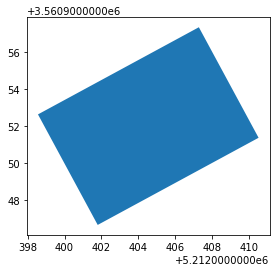

In [52]:
#import packages
import matplotlib.pyplot as plt

# plot the footprint of the first building of the gdf
gdf.iloc[[0]].plot()